v0.1 (04/11/24)

## NeuroMotor Project

In [89]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

import scipy.signal as sig

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


path_all = '../RepositoryData'
plt.style.use('seaborn-v0_8-bright')


## Index:
##### I. Data splitting:
##### II. Denoising and visualizations:
##### III. Transforms:

I.i Loading data

In [90]:
# Path set up
single_subject = path_all + '/SL01-T01'
sgl_subj_eeg = single_subject + '/eeg.txt'

I.ii Obtaining time intervals of interest

In [91]:
# Setting time intervals
t_walk_min = [2, 17]# the data we want from 2min to 17min with fs = 100Hz
t_first_5=[2,7]
t_first_ten=[2,12]
t_stand_min = [0, 2]
t_walkBCI_min = [17, 22]
t_stand_min_2 = [22, 24]
fs = 100

# Seperates into time periods for walking so that data scarcity can be simulated later
t_walk_data = {'t_start_walk': t_walk_min[0]*60*fs, 't_end_walk': t_walk_min[1]*60*fs}
t_walk_data5 = {'t_start_walk': t_first_5[0]*60*fs, 't_end_walk': t_first_5[1]*60*fs}
t_walk_data10 = {'t_start_walk': t_first_ten[0]*60*fs, 't_end_walk': t_first_ten[1]*60*fs}

# Data that probably wont be used but good to have handel for
t_stand_data = {'t_start_stand': t_stand_min[0]*60*fs, 't_end_stand': t_stand_min[1]*60*fs}
t_walkBCI_data = {'t_start_walkBCI': t_walkBCI_min[0]*60*fs, 't_end_walkBCI': t_walkBCI_min[1]*60*fs}
t_stand_data_2 = {'t_start_stand_2': t_stand_min_2[0]*60*fs, 't_end_stand_2': t_stand_min_2[1]*60*fs}

# all non-BCI data (probably wont be used)
t_useful_data = {'t_start_useful_1': t_stand_data['t_end_stand'], 't_end_useful_1': t_walk_data['t_start_walk'], 't_start_useful_2': t_stand_data_2['t_end_stand_2']}

I.iii Loading dependent variables

In [92]:
# Load the data
eeg = pd.read_csv(sgl_subj_eeg, sep='\t', on_bad_lines='warn', skiprows=1, header=None)
eeg.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
time = eeg.iloc[:, 0]
eeg = eeg.iloc[:, 1:]

# drops unwanted sections
eeg_walk=eeg.drop(range(t_walk_data['t_start_walk']))
eeg_walk=eeg_walk.drop(range(t_walk_data['t_end_walk']-1, eeg_walk.index[-1]))
eeg_walk = eeg_walk.to_numpy()
perform_drop=len(eeg_walk)==t_walk_data['t_end_walk']- t_walk_data['t_start_walk']

# checks to make sure desired rows were dropped
if perform_drop:
    print('Drop successful')
else:
    print('Length of array is: ' + str(len(eeg_walk)))
    print(' but is supposed to be '+ str(t_walk_data['t_end_walk']- t_walk_data['t_start_walk']))

# drops unwanted sections
time_walk=time.drop(range(t_walk_data['t_start_walk']))
time_walk=time_walk.drop(range(t_walk_data['t_end_walk']-1, time_walk.index[-1]))
time_walk = time_walk.to_numpy()

# For general checking of data:
eeg = eeg.to_numpy()
time = time.to_numpy()
print(eeg.shape, time.shape)


Drop successful
(137242, 64) (137242,)


I.iv Loading dependent variables

In [93]:
# Loading dependent variable
sgl_joint_angl=single_subject+'/joints.txt'

# Remove the first 2 lines of the file using skiprows
j_angl = pd.read_csv(sgl_joint_angl, sep='\t', header=None ,names=list(range(14)), skiprows=2)

# processing data
j_angl.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
j_time = j_angl.iloc[:, 0]
j_angl = j_angl.drop(0, axis=1)
j_angl = j_angl.drop(range(7,13), axis=1) # we only want actual joint angles for testing 7-13 are predictions
print(j_angl.head())

# selects sections we want from joint data
j_walk=j_angl.drop(range(t_walk_data['t_start_walk']))
j_walk=j_walk.drop(range(t_walk_data['t_end_walk']-1, j_walk.index[-1]))
j_walk = j_walk.to_numpy()


      1      2      3     4      5     6
0  1.44 -6.435 -3.375 -1.26  1.125  3.06
1  1.44 -6.435 -3.375 -1.26  1.125  3.06
2  1.44 -6.435 -3.375 -1.26  1.125  3.06
3  1.44 -6.435 -3.375 -1.26  1.125  3.06
4  1.44 -6.435 -3.375 -1.26  1.125  3.06


II.i Visualizing dataset before noise removal

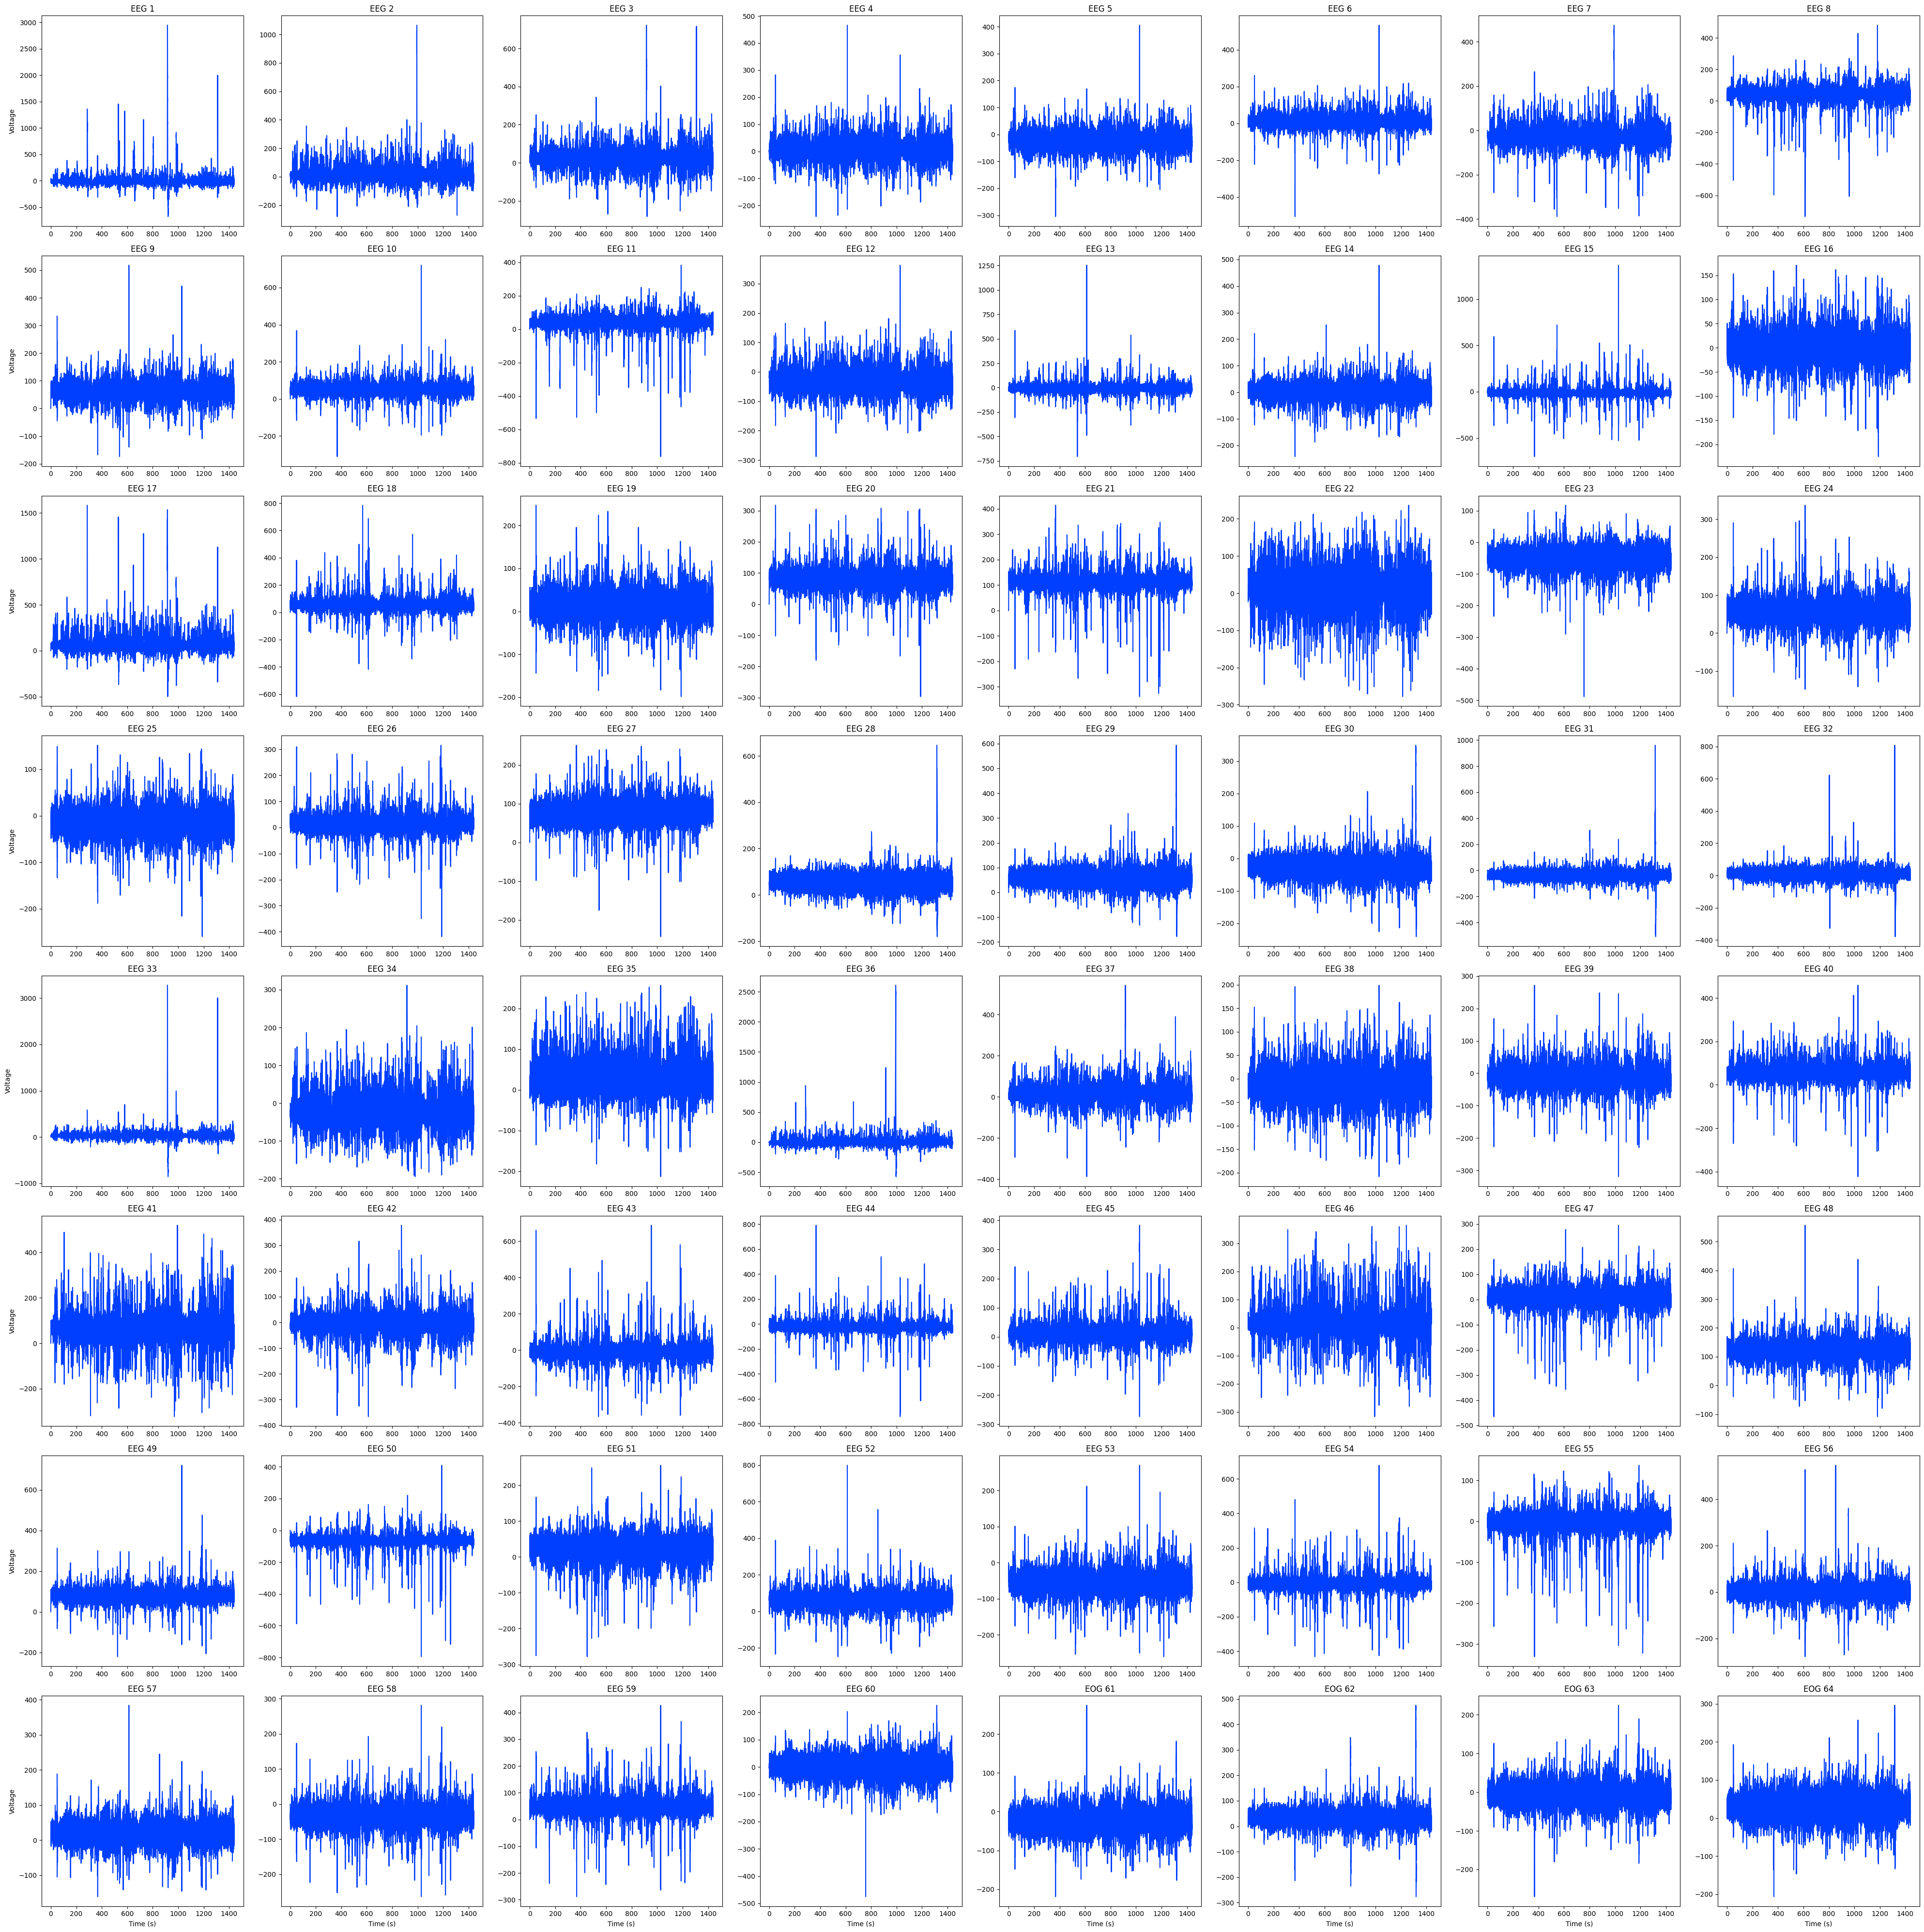

In [94]:
# plot 64 channels in 8x8 grid, label the last 4 channels as EOG, and first 60 as EEG
def visualize_subject_eeg(eeg, time):
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            axs[i, j].plot(time, eeg[:, i * 8 + j])
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.show()

visualize_subject_eeg(eeg, time)

In [95]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

II.ii Applying lowpass filter

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4


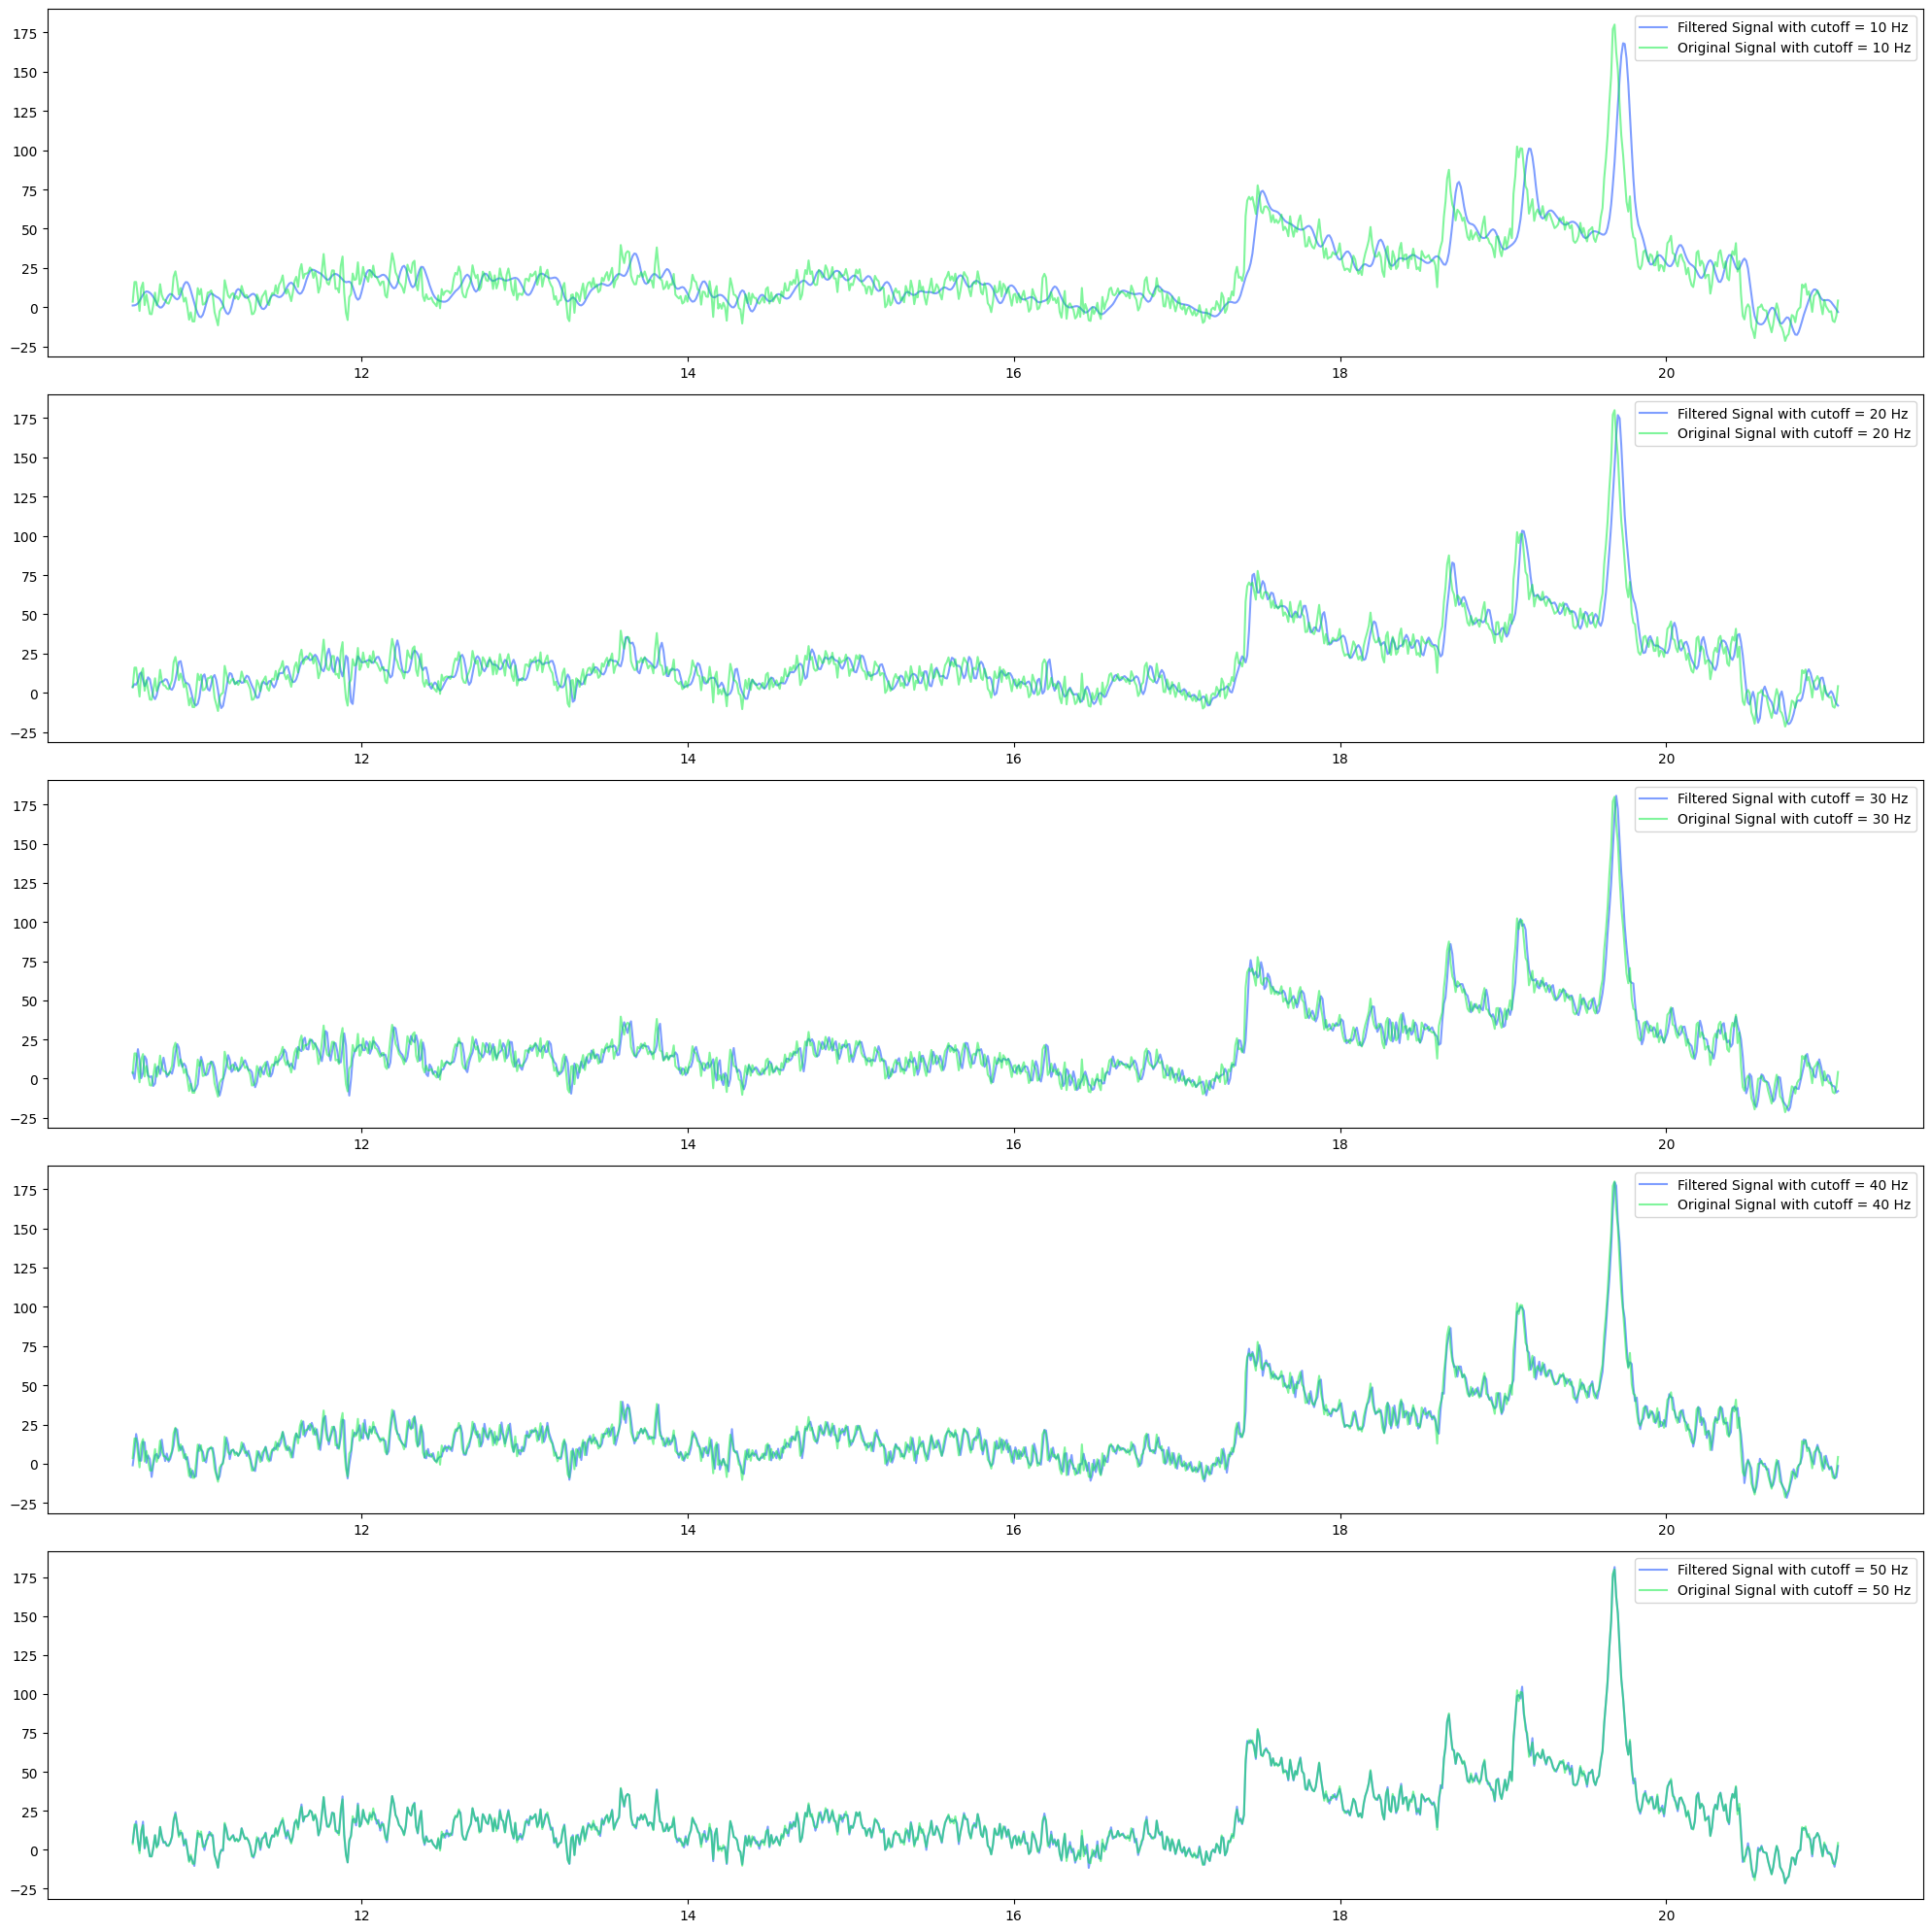

In [96]:
def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

# y = lp(channel_1, 40)
figsize = (20, 20)

fig, axs = plt.subplots(5, 1, figsize=figsize)

for i in range (1, 6):
    index=i-1
    print(f"loop: {index}")
    y = eeg[:, 1]
    y_f = lp(y, i * 10) if i != 5 else lp(y, 49)
    axs[index].plot(time[1000:2000], y_f[1000:2000], alpha=.5, label=f"Filtered Signal with cutoff = {i*10} Hz")
    axs[index].plot(time[1000:2000], y[1000:2000], alpha=.5, label=f"Original Signal with cutoff = {i*10} Hz")
    axs[index].set_xlabel('Time (s)') if index == 5 else None
    axs[index].legend()

plt.tight_layout()
plt.show()

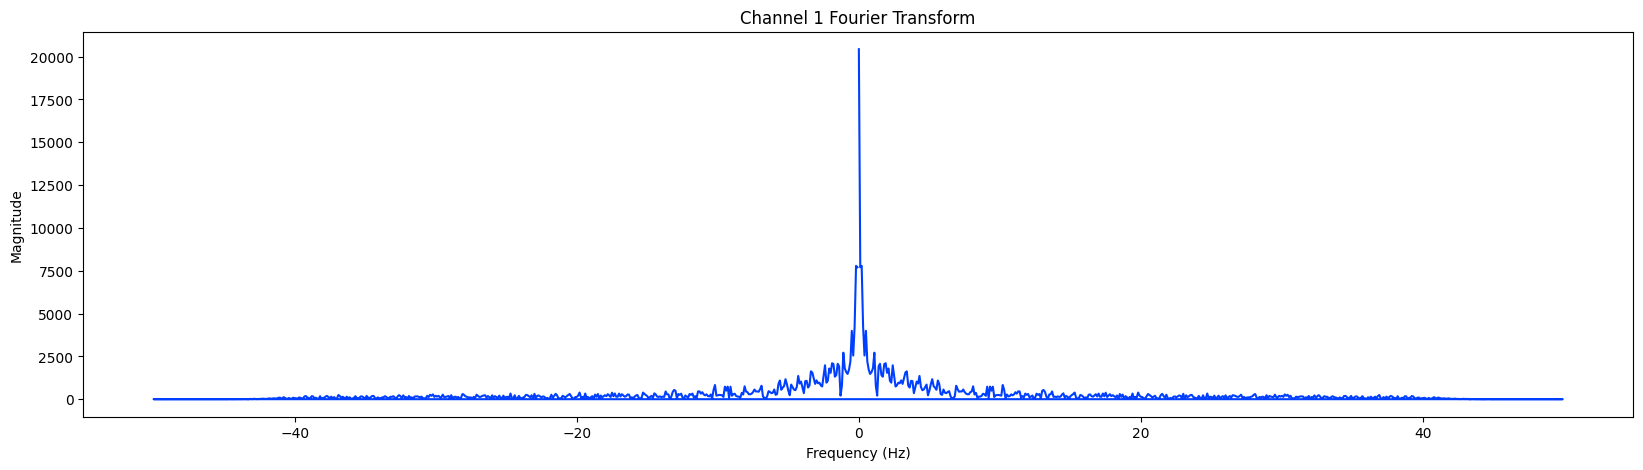

In [97]:
# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)
    f = np.fft.fftfreq(n, 1/fs)
    y = np.fft.fft(data)
    return f, y

channel_1 = eeg[:, 1]

# filter the signal
channel_1_f = lp(channel_1, 40)
# get the fourier transform
f, y = fourier_transform(channel_1_f[1000:2000], 100)

plt.figure(figsize=(20, 5))
plt.plot(f, np.abs(y))
plt.title('Channel 1 Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

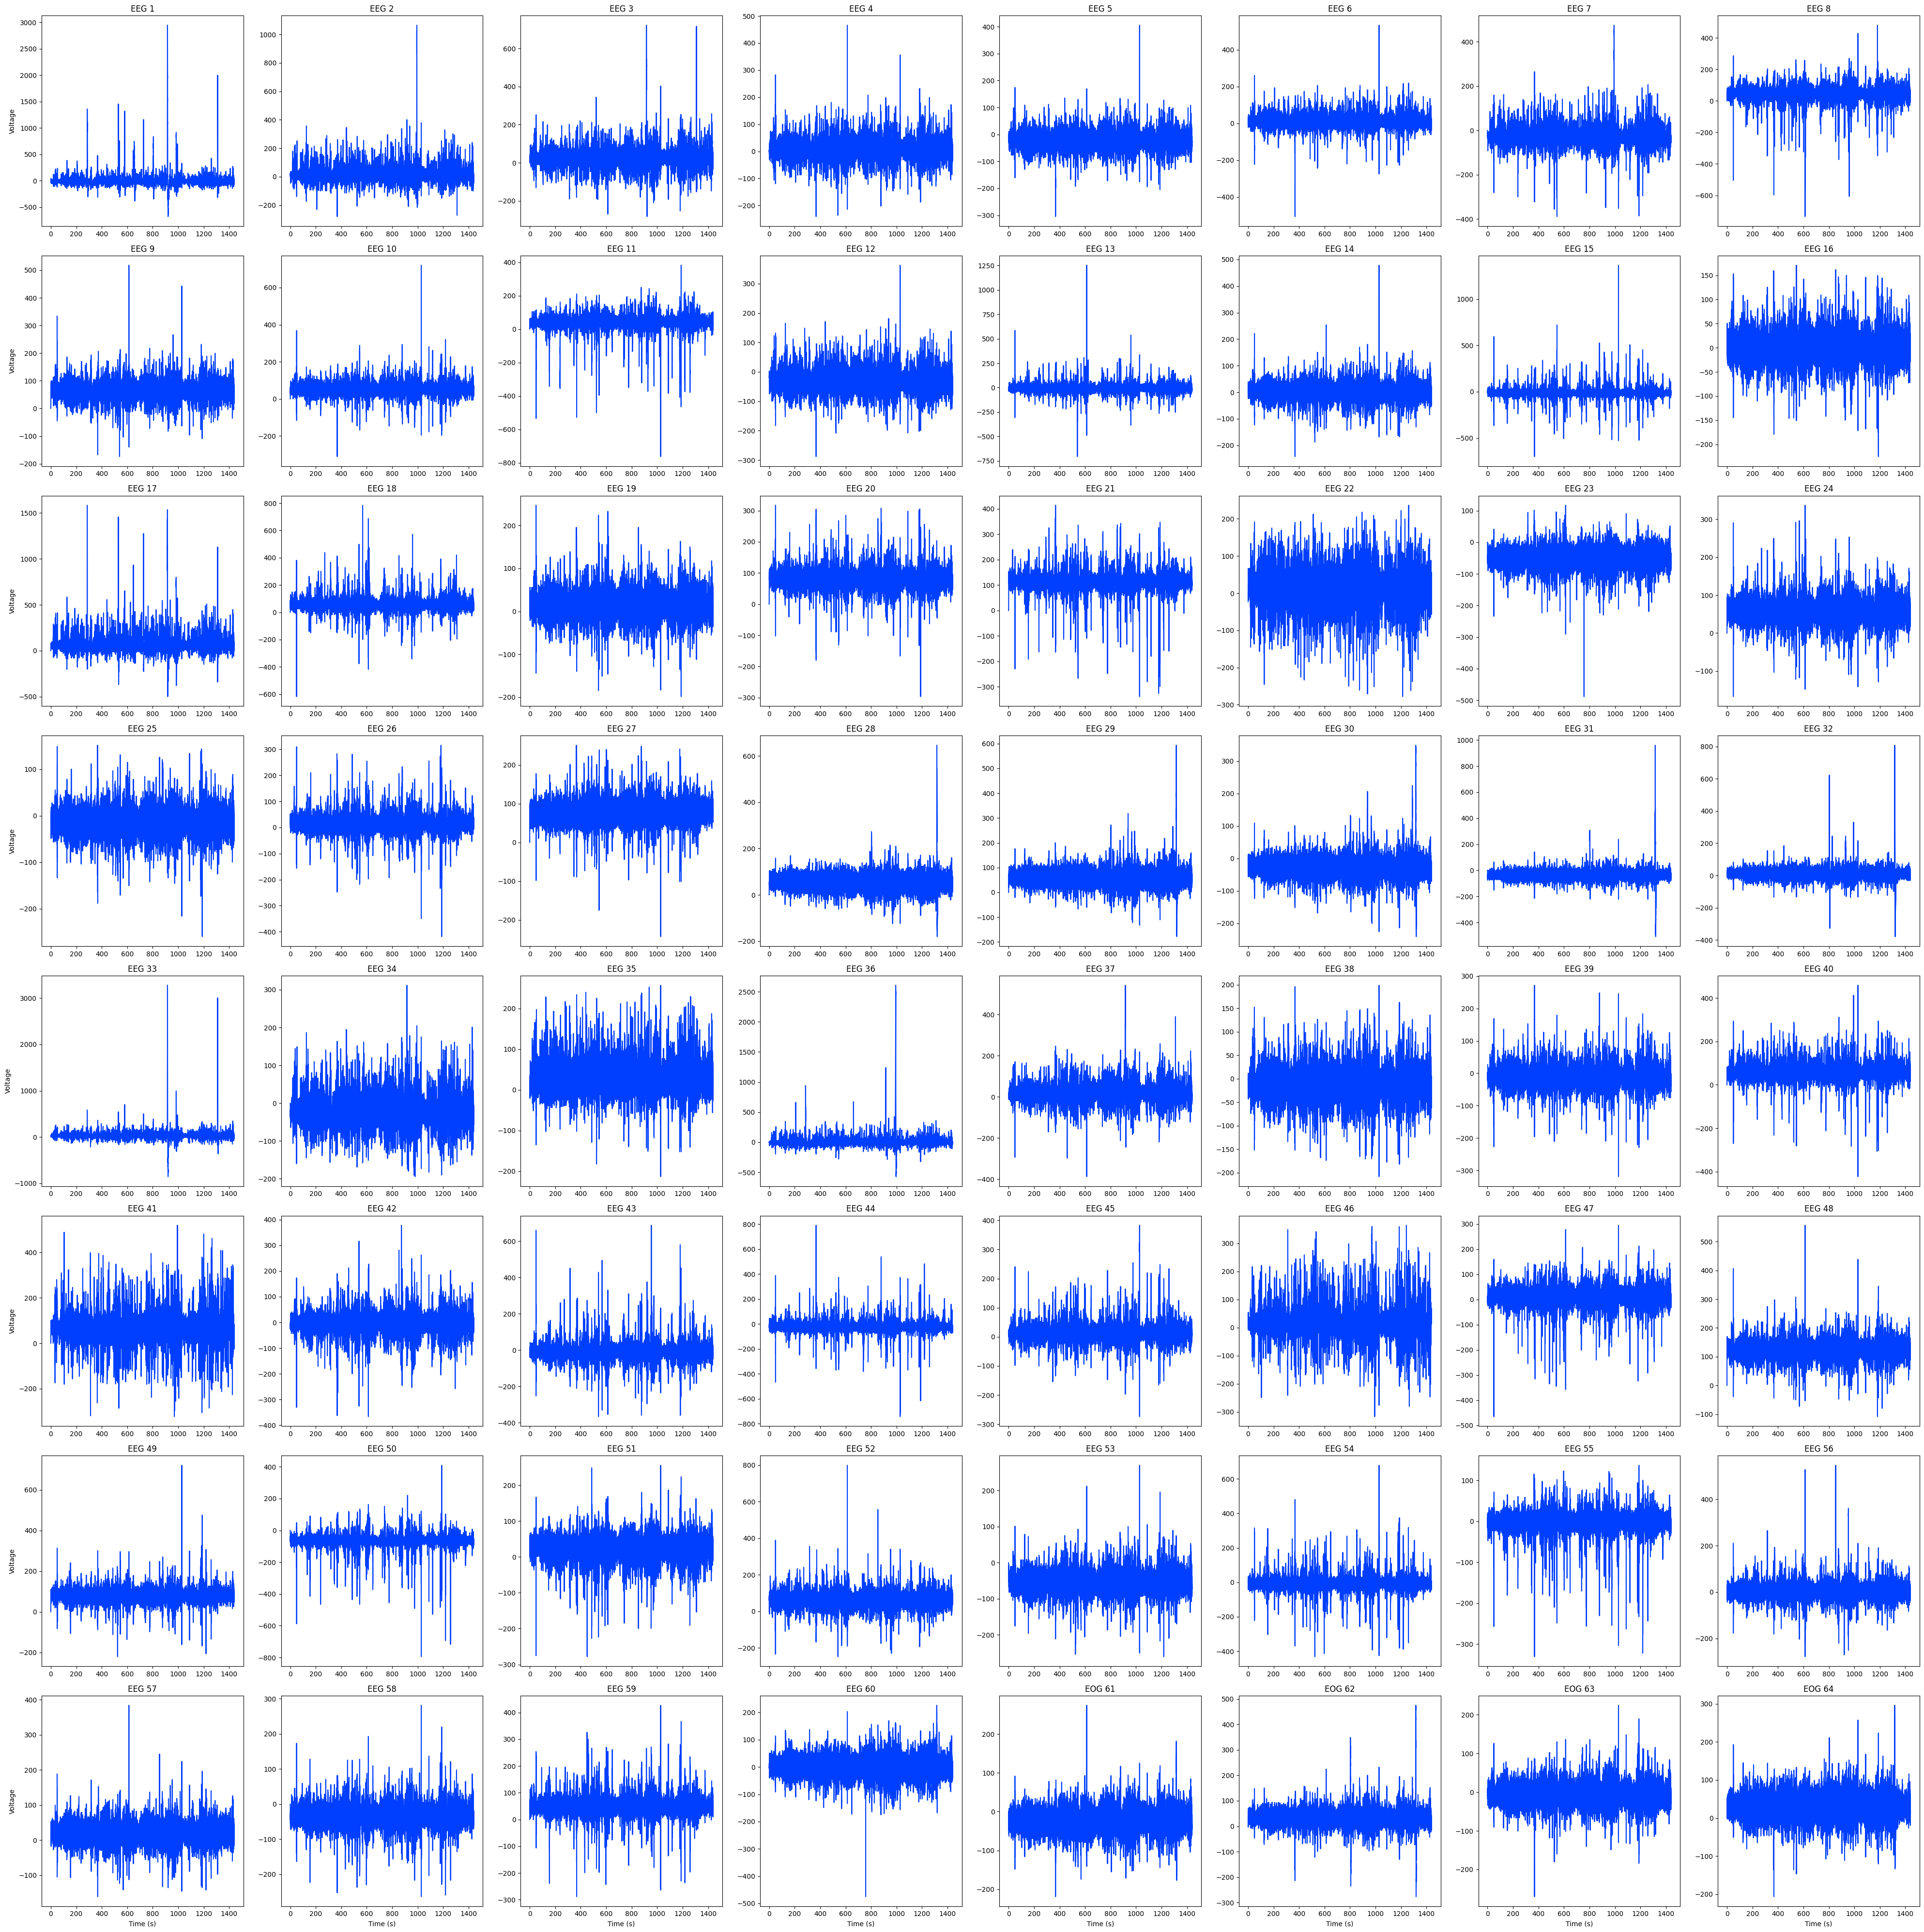

In [98]:
def visualize_subject_eeg_flt(eeg, time):

    eeg_f = lp_50(eeg)
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            # axs[i, j].plot(time, eeg[:, i * 8 + j], label="o", alpha=.3)
            axs[i, j].plot(time, eeg_f[:, i * 8 + j], label="f", alpha=.3)
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.legend()
    plt.show()

visualize_subject_eeg(eeg, time)

Implementing PCA:

In [99]:
# Start with normalizing the data with regard to independent variable
scaler = StandardScaler()
eeg_norm = scaler.fit_transform(eeg)

In [101]:
# PCA
pca = PCA(random_state=1)
pca.fit(eeg_walk)
eeg_walk_pca = pca.transform(eeg_walk)

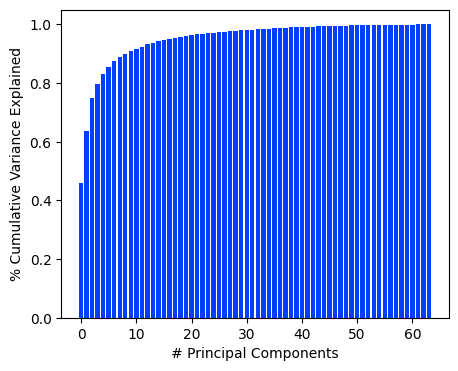

In [102]:
# Calculate cumulative explained variance across all PCs
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(range(64), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [103]:
# Select number of components based on graph
pca = PCA(n_components=8, random_state=1)
pca.fit(eeg_walk)
eeg_walk_pca = pca.transform(eeg_walk)
eeg_walk_rec = pca.inverse_transform(eeg_walk_pca)
for numb in range(8):
    print('The variance explained by component '+ str(numb)+ ' is '+str(round(100* pca.explained_variance_ratio_[numb]))+ '%')

The variance explained by component 0 is 46%
The variance explained by component 1 is 18%
The variance explained by component 2 is 11%
The variance explained by component 3 is 5%
The variance explained by component 4 is 3%
The variance explained by component 5 is 2%
The variance explained by component 6 is 2%
The variance explained by component 7 is 1%


II. Visualizing PCA across all channels

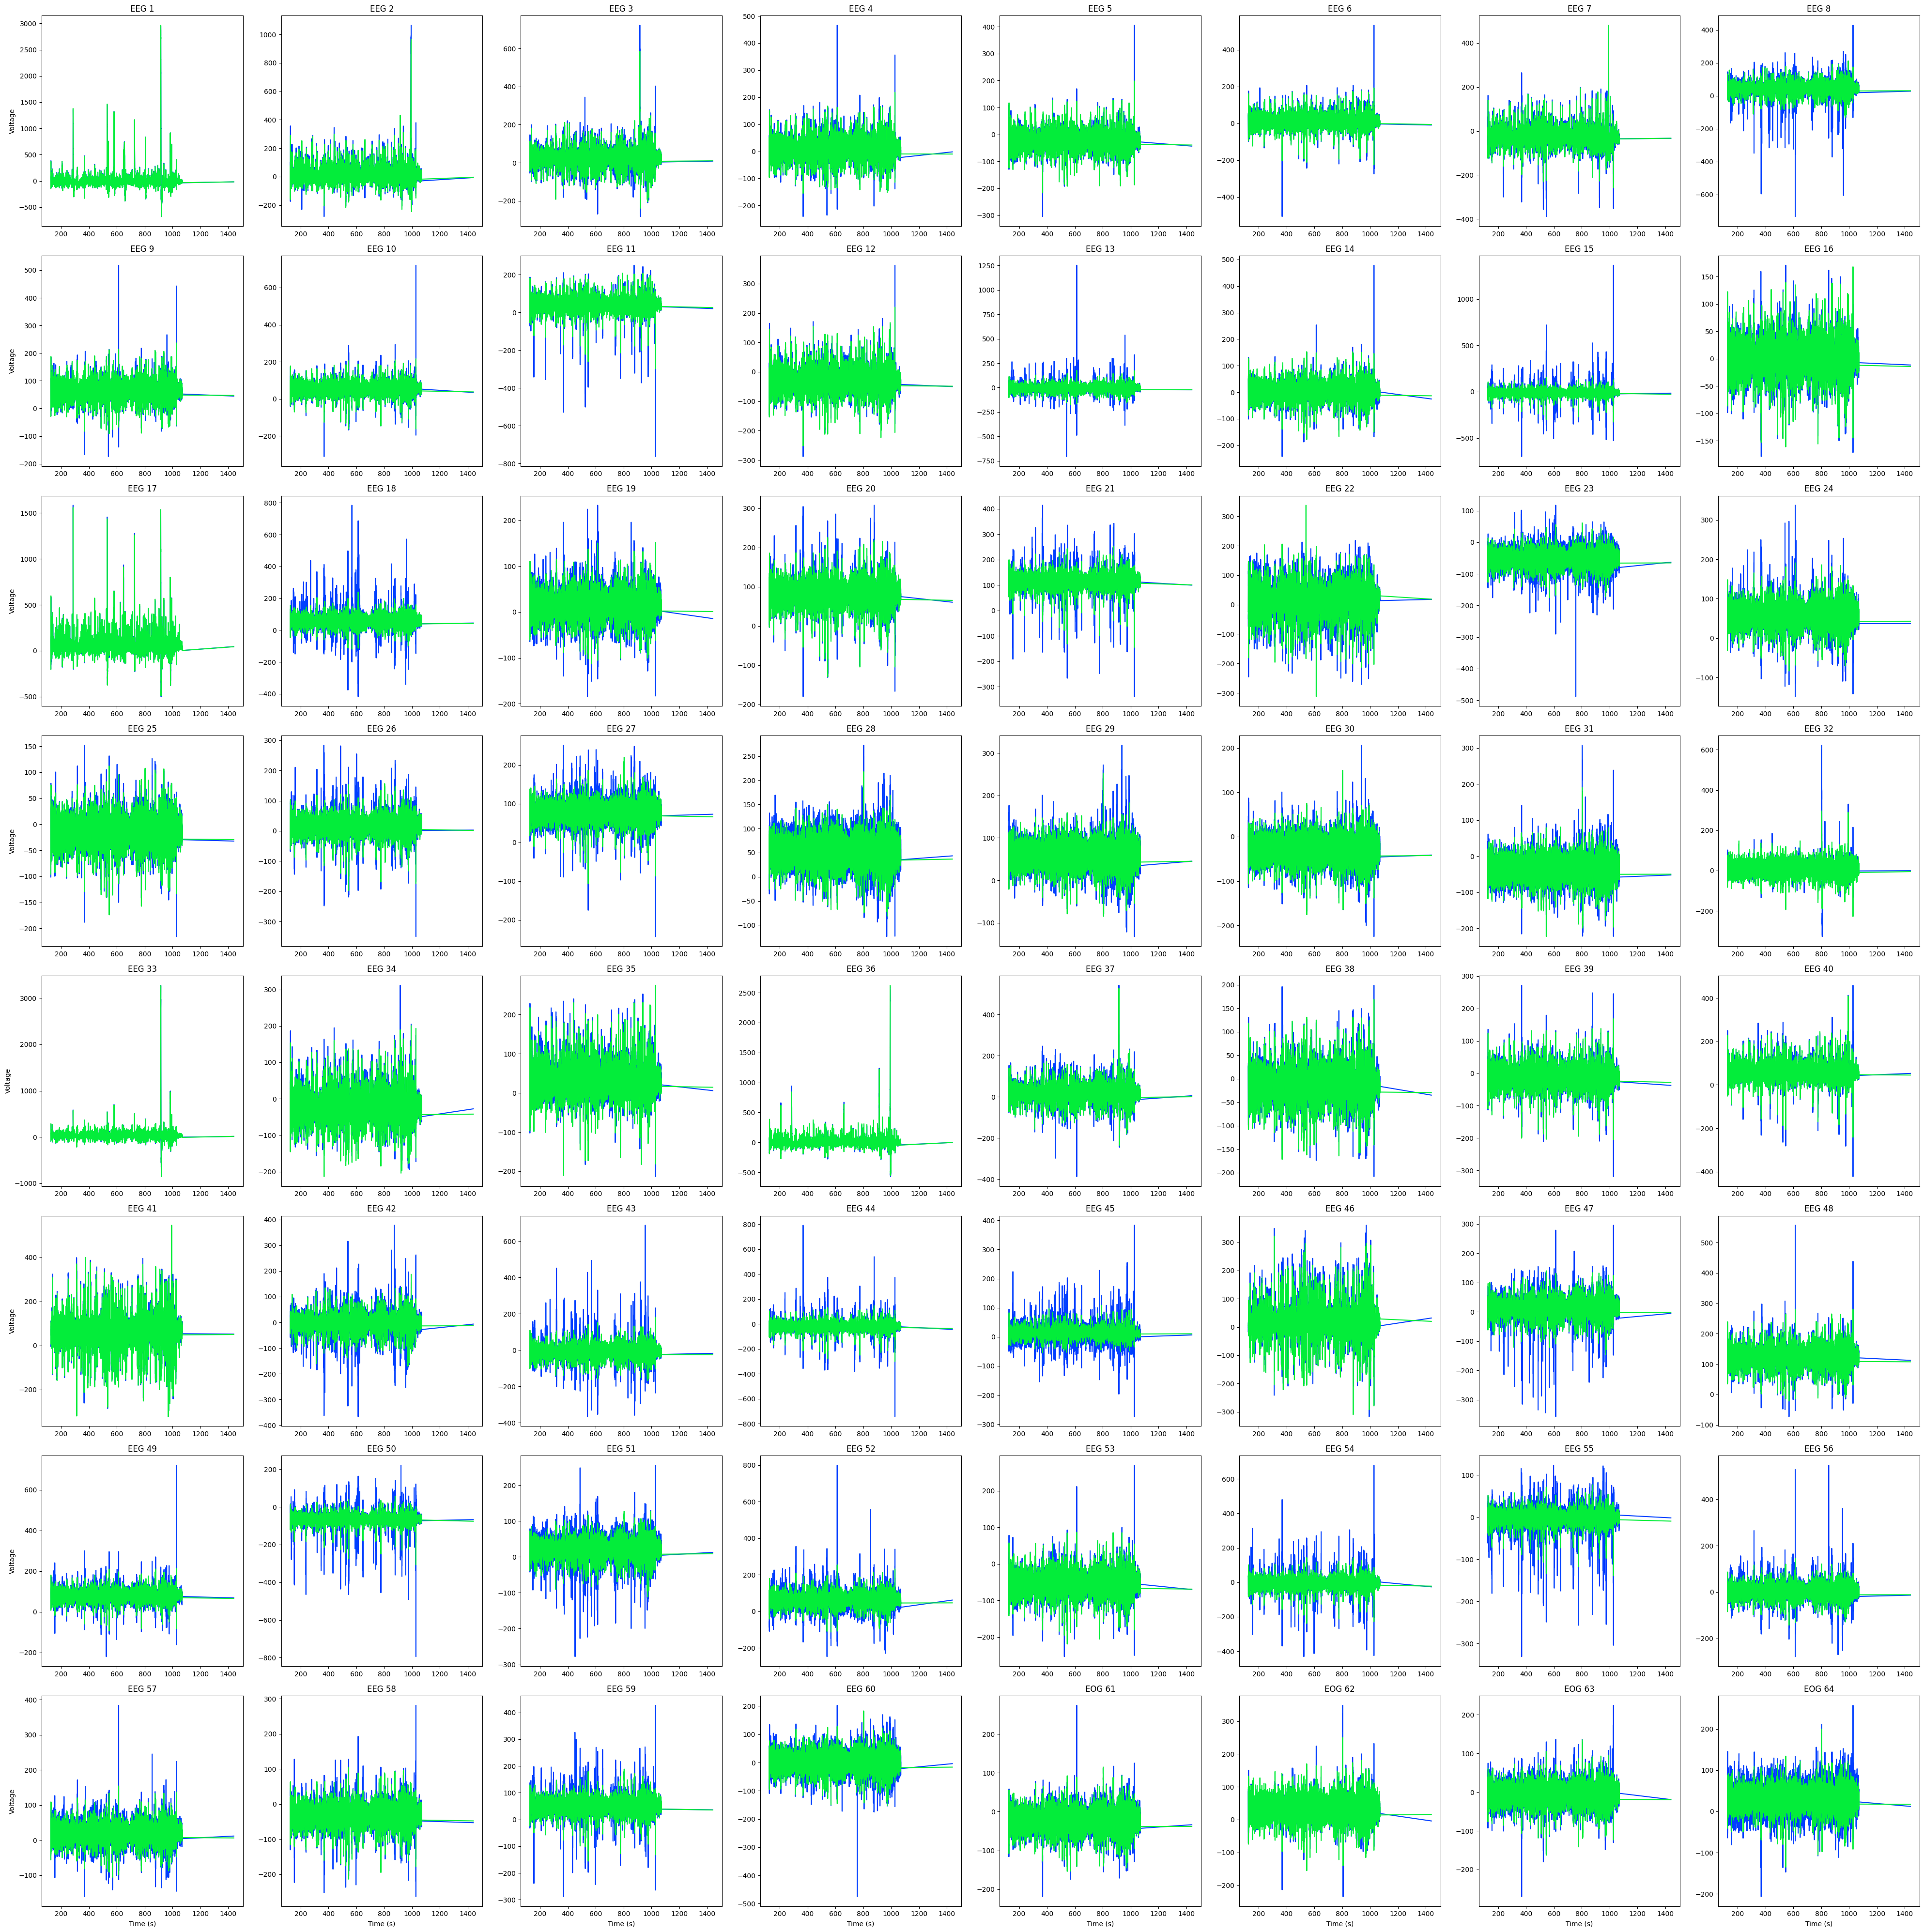

In [104]:
# plot 64 channels in 8x8 grid, label the last 4 channels as EOG, and first 60 as EEG
def visualize_subject_eeg(eeg_walk,pca_walk, walk_time):
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            axs[i, j].plot(walk_time, eeg_walk[:, i * 8 + j])
            axs[i, j].plot(walk_time, pca_walk[:, i * 8 + j])
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.show()

visualize_subject_eeg(eeg_walk,eeg_walk_rec, time_walk)

Appendix: Cool if we could get this to work in python, but might only work in matlab

In [133]:
# Electrode labeling

# Loading electrode labels
sgl_ele_labels=single_subject+'/impedances-before.txt'

# Remove the first 2 lines of the file using skiprows
ele_imp = pd.read_csv(sgl_ele_labels, sep='\t', header=None , skiprows=20, names=list(range(5)))

ele_labels=ele_imp[1]
ele_labels=ele_labels.drop(0)


EOG_labels=[' TP9', 'TP10', ' FT9', 'FT10']
EOG_labels=ele_labels[ele_labels.iloc[:].isin(EOG_labels)]
EOG_indx=EOG_labels.index

# further processing
ele_labels.drop(ele_labels.tail(2).index,inplace=True)
ele_labels=list(ele_labels)


In [263]:
# XML reader to convert .bvcf into usable spatial data

import xml.etree.ElementTree as Xet 
import pandas as pd 
from bs4 import BeautifulSoup   

path_to_dig = single_subject + '/digitizer.bvcf' 
cols = ['Name', 'X', 'Y', 'Z', 'Theta', 'Phi', 'Radius', 'Channel'] 
rows = [] 

# Opening file
file = open(path_to_dig ,'r') 
contents = file.read()
soup = BeautifulSoup(contents,'xml')

Name = soup.find_all('Name')
X = soup.find_all('X')
Y = soup.find_all('Y')
Z = soup.find_all('Z')
Theta = soup.find_all('Theta')
Phi = soup.find_all('Phi')
Radius = soup.find_all('Radius')
Channel = soup.find_all('Channel')

# Check if any of the elements are None
data = [] 
# chan_dict={}
for i in range(0,len(Name)): 
   rows = [Name[i].get_text(),X[i].get_text(), 
           Y[i].get_text(),Z[i].get_text(), 
           Theta[i].get_text(),Phi[i].get_text(),
           Radius[i].get_text(), Channel[i].get_text()] 
   data.append(rows)

   # chan_dict[i]={Name[i].get_text(): str([X[i].get_text(), 
           # Y[i].get_text(),Z[i].get_text()])}

Spatial_data = pd.DataFrame(data, columns=cols)
x=Spatial_data['X'].astype(float).to_numpy()
y=Spatial_data['Y'].astype(float).to_numpy()
x=x/(np.max(x)-np.min(x))
y=y/(np.max(y)-np.min(y))
xy=np.stack((x, y), axis=1)

In [247]:
np.stack((x, y), axis=1)


array([[ 1.79247981e+01, -5.11182134e+00],
       [ 1.43421278e+01, -1.15737977e+01],
       [ 1.28212406e+01, -1.55718765e+01],
       [ 1.58667265e+01, -1.10977433e+01],
       [ 1.83638062e+01,  7.24948444e+00],
       [ 1.87407263e+01, -2.86651843e-13],
       [ 1.82958784e+01,  7.67695692e-01],
       [ 1.68739637e+01, -5.83593714e+00],
       [ 1.77186074e+01,  7.20042531e+00],
       [ 1.44159195e+01,  7.11579875e+00],
       [ 1.44652366e+01,  1.53461292e-01],
       [ 1.52105315e+01,  1.34017968e+01],
       [ 1.31774397e+01,  1.73867616e+01],
       [ 1.64935186e+01,  1.25168575e+01],
       [ 1.19613964e+01,  1.36827874e+01],
       [ 1.29213943e+01,  1.80433871e+01],
       [ 7.49843884e+00,  2.08353795e+01],
       [ 8.34988657e+00,  1.79051979e+01],
       [ 1.38790478e+00,  2.18405941e+01],
       [ 1.21817033e+00,  1.87446767e+01],
       [-4.33452479e+00,  2.02118219e+01],
       [-5.83373496e+00,  1.76682792e+01],
       [-5.19806134e+00,  1.33036959e+01],
       [ 7.

In [147]:
# If we could get this to work we could visualize the ICA
import mne 
import defusedxml.ElementTree
channels=len(Spatial_data['Name'])

# channel type from literature
chan_type=['eeg']*channels
for EoG in EOG_indx:
    chan_type[EoG]='eog'

mne_info = mne.create_info(ch_names=list(Spatial_data['Name']),
                    sfreq=fs,
                    ch_types=chan_type)

mne_raw = mne.io.RawArray(eeg_walk[:,:channels].transpose(), mne_info)
# Defining the electrodes architecture


Creating RawArray with float64 data, n_channels=63, n_times=90000
    Range : 0 ... 89999 =      0.000 ...   899.990 secs
Ready.


In [278]:
# montage=mne.channels.make_dig_montage(chan_dict, coord_frame='head')

Layout2D=mne.channels.generate_2d_layout(xy, Spatial_data['Name'].to_numpy(), normalize=True)
walk=pd.DataFrame(eeg_walk[:,:channels]).astype(float)
walk=walk.mean()
walk.shape




(63,)

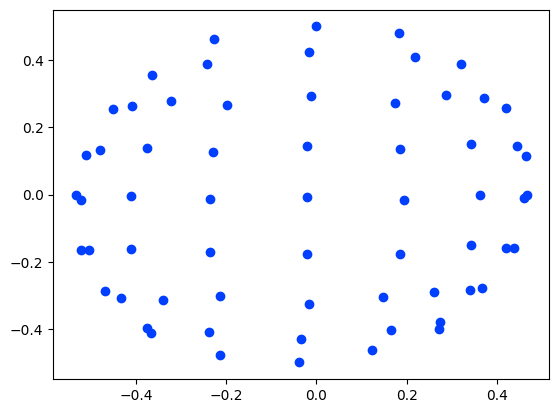

In [264]:
plt.scatter(x,y)


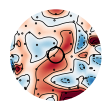

(<matplotlib.image.AxesImage at 0x7fa797e30610>,
 <matplotlib.contour.QuadContourSet at 0x7fa797e30790>)

In [280]:
from mne.viz import plot_topomap
plot_topomap(data=walk.transpose(), pos=xy, ch_type=chan_type)